Exploratory Data Analysis 

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table, show_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot, df_to_pdf, plot_to_pdf
from utilities_widgets import position_chart
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    file = re.sub(r'\W', '_', glob.tooling)
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [3]:
""" ##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[0]
default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[0]
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter=file+"_FixtureData_")[-1]
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'}) """

' ##Database access\ntable_list = consult_database("input.db", verbose=False)\nfile = re.sub(r\'\\W\', \'_\', glob.tooling)\ndefault_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[0]\ndefault_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[0]\ntry: #Tries to find a table for the fixture data\n    fixture_data = consult_database("input.db", verbose=False, filter=file+"_FixtureData_")[-1]\n    value=(default_measurements, default_limits, fixture_data)\nexcept:\n    value=(default_measurements, default_limits)\ntables = widgets.SelectMultiple(options=table_list, value=value, description=\'input db\', rows=10, layout={\'width\': \'600px\'}) '

In [4]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
#FIXTURE_DATA.set_index('index', inplace=True)
#display(FIXTURE_DATA.iloc[0:])
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('MID_GOLF_PA_Fi…

Table *MID_GOLF_PA_Measurements_2024y_01m_24d_10h_55m_14s* retrieved succesfully.
Table *MID_GOLF_PA_Limits_2024y_01m_24d_10h_55m_14s* retrieved succesfully.
Table *MID_GOLF_PA_FixtureData_2024y_01m_25d_11h_36m_11s* retrieved succesfully.


In [5]:
##Database management
print(f"File(s) ready to use:")
for table in tables.value:
    print(f"    {table}")

File(s) ready to use:
    MID_GOLF_PA_Measurements_2024y_01m_24d_10h_55m_14s
    MID_GOLF_PA_Limits_2024y_01m_24d_10h_55m_14s
    MID_GOLF_PA_FixtureData_2024y_01m_25d_11h_36m_11s


In [6]:
#Fixture metadata preparation
if "FIXTURE_DATA" not in globals(): #Gets data directly from the globals file
    FIXTURE_DATA = pd.DataFrame.from_records([glob.__dict__]).transpose()
    FIXTURE_DATA.rename(columns={0:"Tooling data"}, inplace=True)
    FIXTURE_DATA.rename(index={"tooling": "Tooling name", "lenses_per_nest": "Lenses per nest", "nests_number": "Number of nests", "x_tolerance":"X-axis tolerance",
                            "y_tolerance":"Y-axis tolerance", "lo_tolerance":"Lower tolerance", "hi_tolerance": "Higher tolerance"}, inplace=True)
print("Fixture metadata:")
display(FIXTURE_DATA)

Fixture metadata:


,Tooling data
Tooling name,MID_GOLF_PA
Lenses per nest,3
Number of nests,4
X-axis tolerance,0.0125
Y-axis tolerance,0.0165
Lower tolerance,0.02
Higher tolerance,0.03


In [7]:
##Measurements preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 21,test: 22,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30
Guia_Luz_Blanco_FB1_X,0.3197,0.3197,0.3181,0.3178,0.3178,0.3181,0.3180,0.3179,0.3179,0.3181,...,0.3180,0.3180,0.3180,0.3180,0.3180,0.3180,0.3180,0.3180,0.3180,0.3180
Guia_Luz_Blanco_FB1_Y,0.3466,0.3466,0.3457,0.3455,0.3455,0.3457,0.3456,0.3455,0.3455,0.3457,...,0.3455,0.3455,0.3455,0.3455,0.3455,0.3455,0.3455,0.3455,0.3455,0.3455
Guia_Luz_Blanco_FB2_X,0.3269,0.3268,0.3255,0.3253,0.3254,0.3255,0.3254,0.3252,0.3254,0.3253,...,0.3251,0.3251,0.3251,0.3251,0.3251,0.3251,0.3251,0.3251,0.3251,0.3251
Guia_Luz_Blanco_FB2_Y,0.3529,0.3528,0.3522,0.3520,0.3520,0.3522,0.3521,0.3519,0.3520,0.3520,...,0.3518,0.3518,0.3518,0.3518,0.3518,0.3518,0.3518,0.3518,0.3518,0.3518
Guia_Luz_Blanco_FB3_X,0.3255,0.3255,0.3249,0.3248,0.3249,0.3248,0.3248,0.3248,0.3248,0.3248,...,0.3247,0.3248,0.3246,0.3246,0.3247,0.3247,0.3246,0.3247,0.3247,0.3246
Guia_Luz_Blanco_FB3_Y,0.3527,0.3527,0.3524,0.3524,0.3524,0.3523,0.3523,0.3523,0.3523,0.3523,...,0.3522,0.3522,0.3521,0.3521,0.3522,0.3522,0.3521,0.3522,0.3522,0.3521
Guia_Luz_Blanco_FB4_X,0.3245,0.3242,0.3225,0.3225,0.3225,0.3219,0.3222,0.3221,0.3221,0.3219,...,0.3219,0.3221,0.3218,0.3218,0.3221,0.3218,0.3221,0.3221,0.3218,0.3224
Guia_Luz_Blanco_FB4_Y,0.3495,0.3493,0.3484,0.3484,0.3484,0.3481,0.3483,0.3481,0.3481,0.3481,...,0.3481,0.3481,0.3480,0.3480,0.3481,0.3480,0.3481,0.3481,0.3480,0.3483
Guia_Luz_Blanco_FB5_X,0.3311,0.3311,0.3281,0.3286,0.3281,0.3281,0.3281,0.3279,0.3279,0.3281,...,0.3279,0.3277,0.3279,0.3277,0.3277,0.3277,0.3277,0.3277,0.3277,0.3277
Guia_Luz_Blanco_FB5_Y,0.3553,0.3553,0.3538,0.3539,0.3538,0.3538,0.3538,0.3536,0.3536,0.3538,...,0.3536,0.3533,0.3536,0.3533,0.3533,0.3533,0.3533,0.3533,0.3533,0.3533


In [8]:
##Limits preparation
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("Limits:")
display(LIMITS_format)

Limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.325,0.358


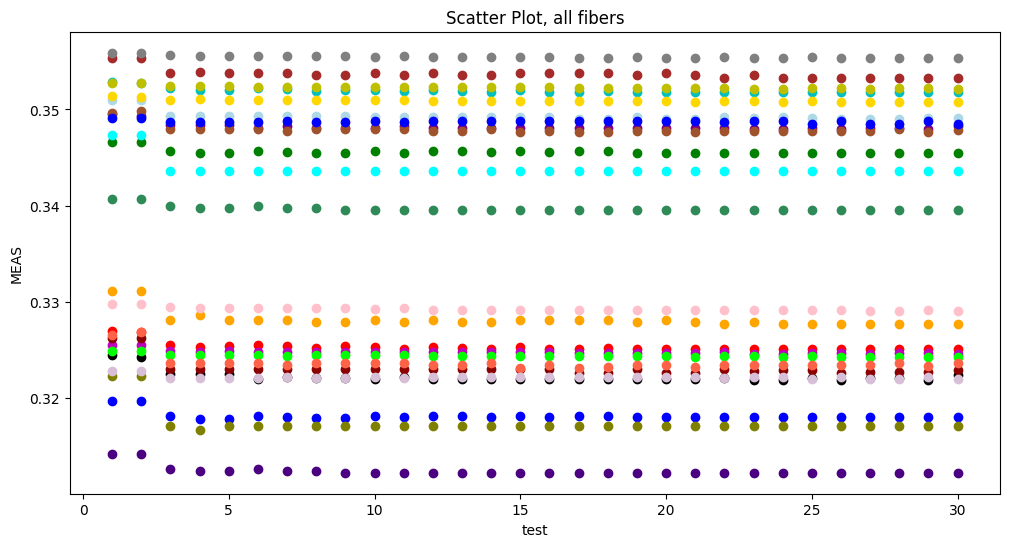

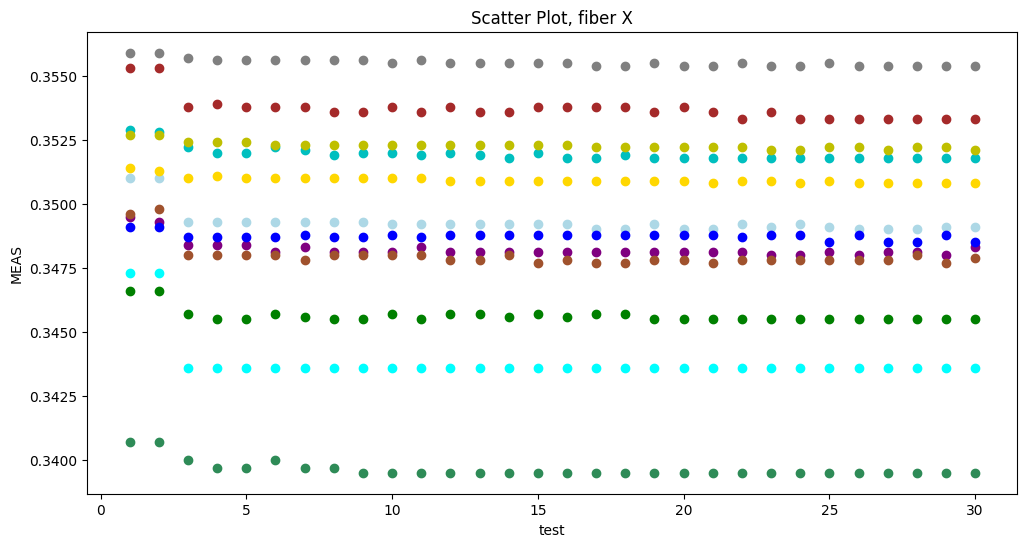

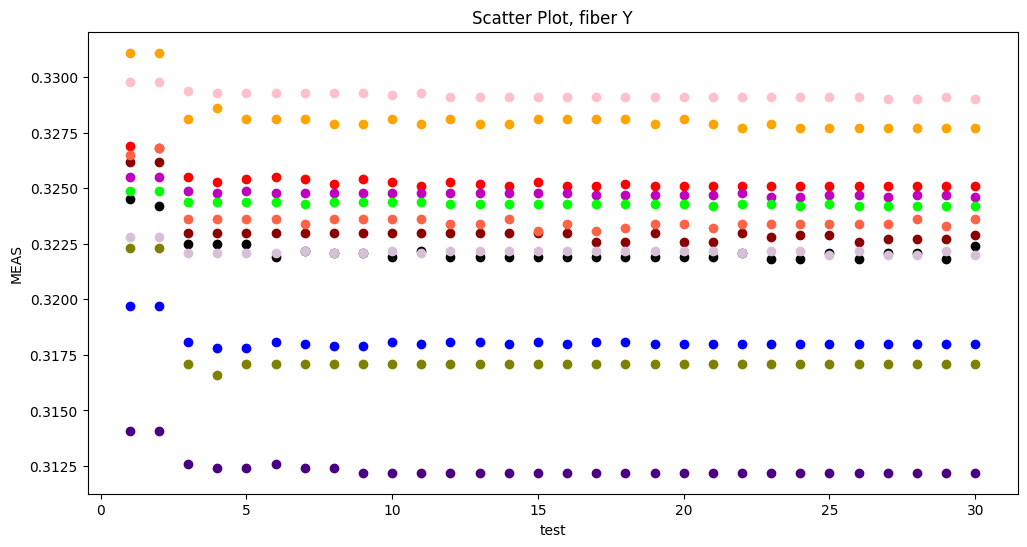

In [9]:
##Visualizations
_ = plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
_ = plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
_ = plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [10]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,30.0,0.318120,0.000437,0.3178,0.318000,0.31800,0.318100,0.3197
Guia_Luz_Blanco_FB1_Y,30.0,0.345637,0.000276,0.3455,0.345500,0.34550,0.345700,0.3466
Guia_Luz_Blanco_FB2_X,30.0,0.325310,0.000439,0.3251,0.325100,0.32510,0.325300,0.3269
Guia_Luz_Blanco_FB2_Y,30.0,0.351960,0.000271,0.3518,0.351800,0.35185,0.352000,0.3529
Guia_Luz_Blanco_FB3_X,30.0,0.324797,0.000208,0.3246,0.324700,0.32480,0.324800,0.3255
Guia_Luz_Blanco_FB3_Y,30.0,0.352277,0.000143,0.3521,0.352200,0.35230,0.352300,0.3527
Guia_Luz_Blanco_FB4_X,30.0,0.322187,0.000626,0.3218,0.321900,0.32190,0.322175,0.3245
Guia_Luz_Blanco_FB4_Y,30.0,0.348223,0.000341,0.3480,0.348100,0.34810,0.348250,0.3495
Guia_Luz_Blanco_FB5_X,30.0,0.328157,0.000825,0.3277,0.327750,0.32790,0.328100,0.3311
Guia_Luz_Blanco_FB5_Y,30.0,0.353717,0.000478,0.3533,0.353375,0.35360,0.353800,0.3553


Analysis of faulty fibers

In [11]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Adds an absolute fiber number for quick identification
LARGEST = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filters the 5 largest values
display(LARGEST)

,std,Fiber number
Guia_Luz_Blanco_FB7_X,0.001327,13
Guia_Luz_Blanco_FB7_Y,0.000939,14
Guia_Luz_Blanco_FB8_X,0.000857,15
Guia_Luz_Blanco_FB11_X,0.000830,21
Guia_Luz_Blanco_FB5_X,0.000825,9


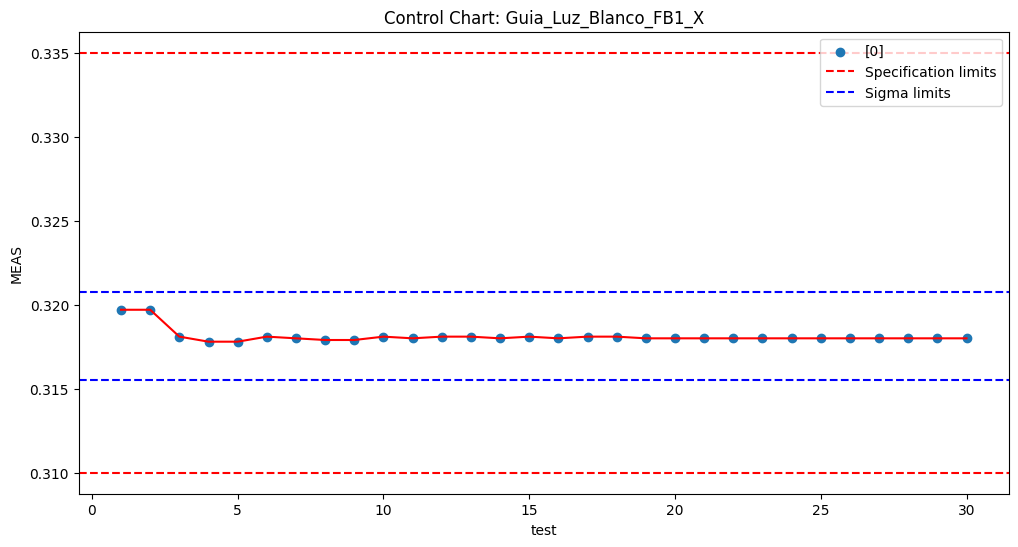

In [12]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title=f'Control Chart: {fiber_selection.value}', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

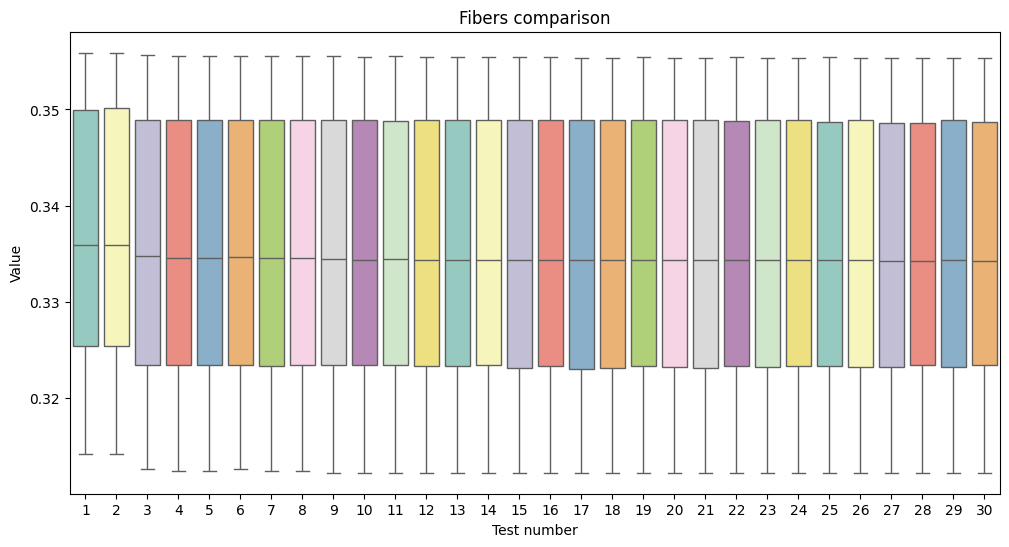

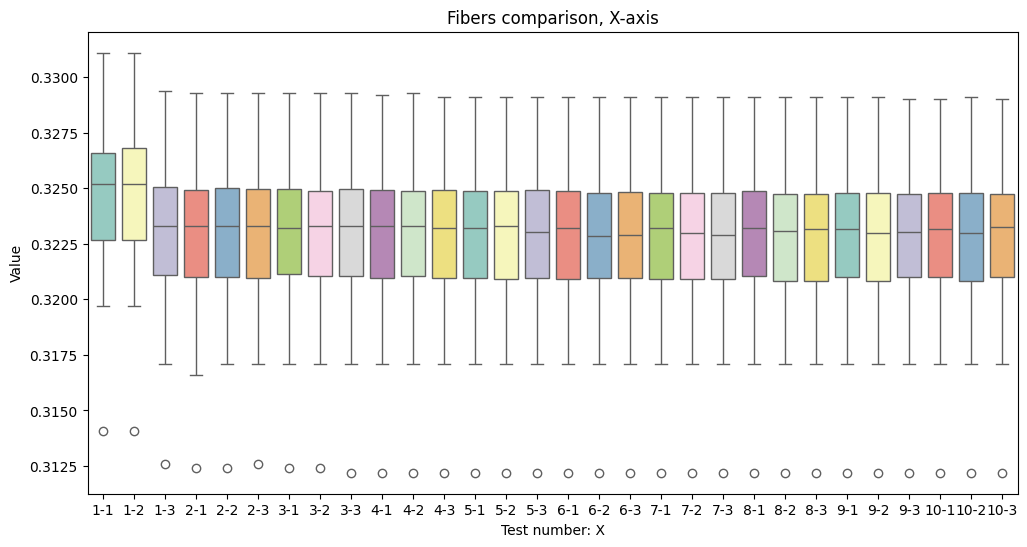

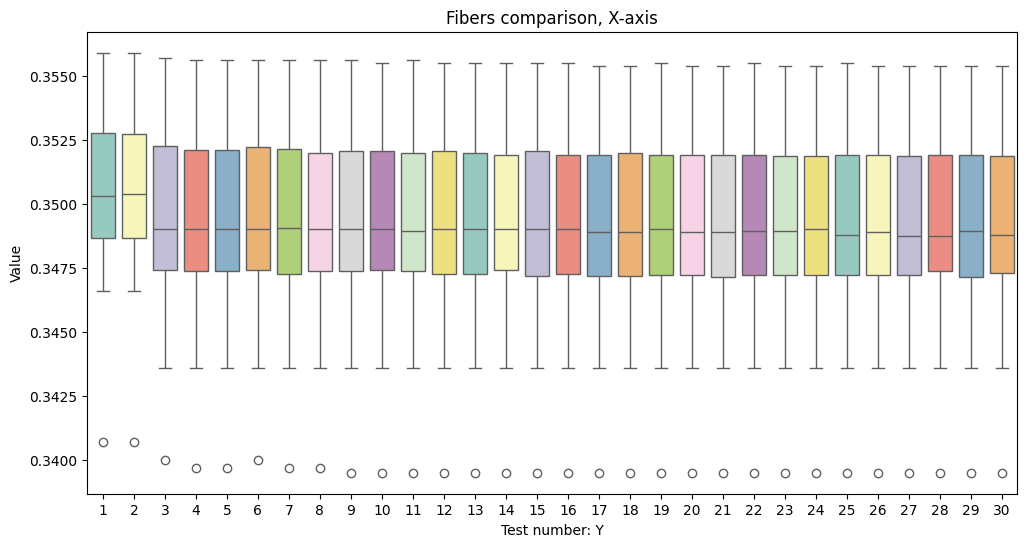

In [13]:
#Subgroups visualizations
plot_boxplot(MEAS_format, title="Fibers comparison", xlabel="Test number", ylabel="Value", filter=None)
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="Y")

In [14]:
#plot_boxplot(MEAS_format.transpose(), title="Fibers comparison", xlabel="Fibers group: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

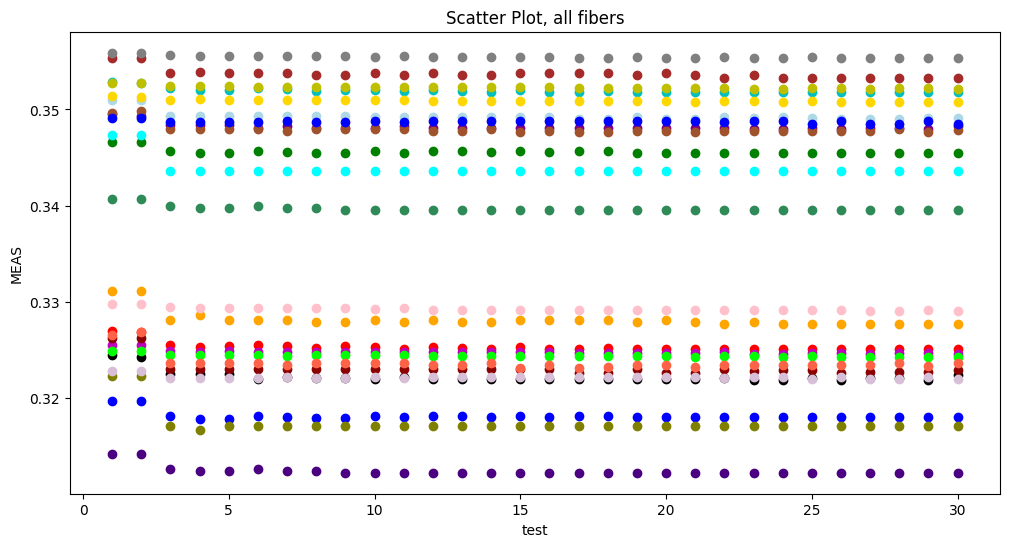

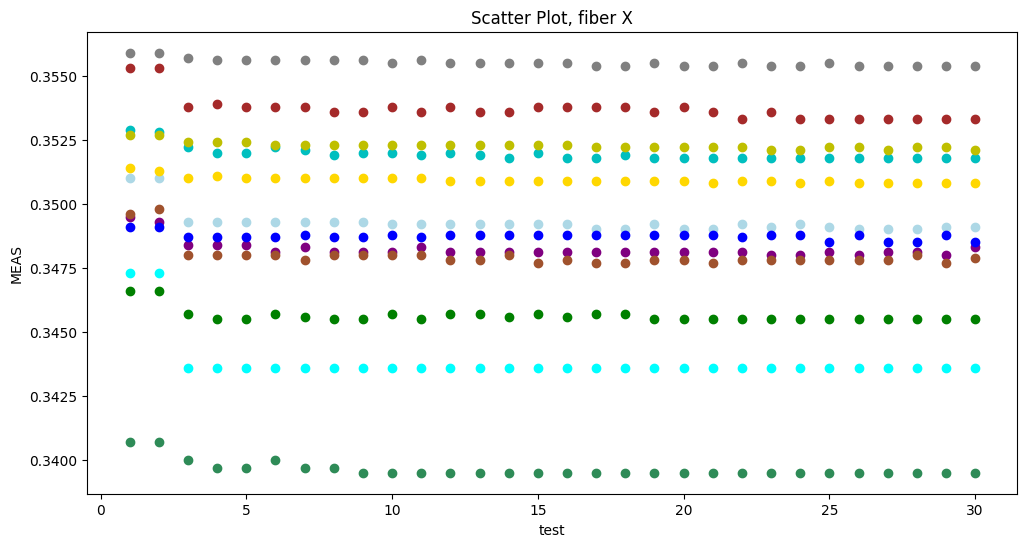

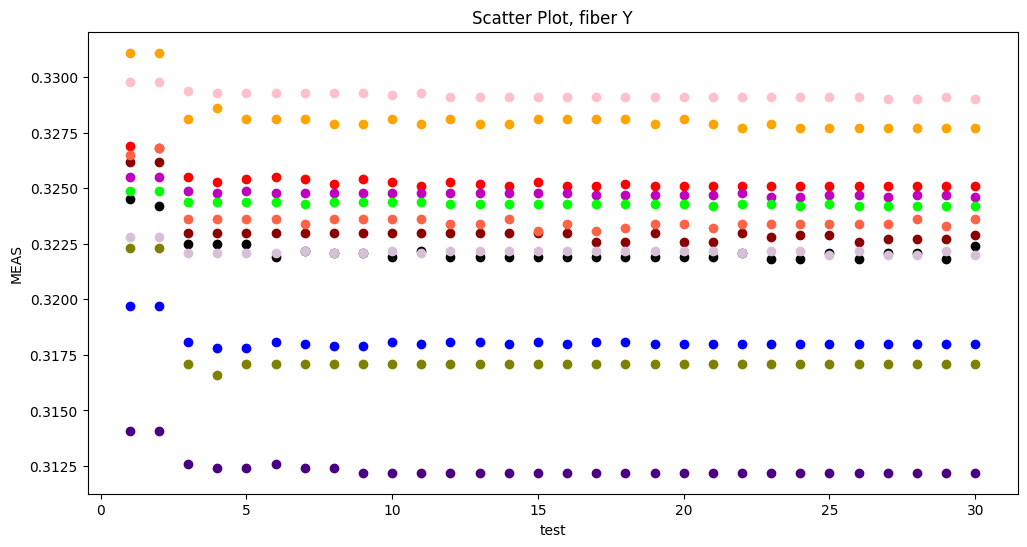

Analysis data and visualizations exported inside:
c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output


In [15]:
######Terminar
##Data export
date = get_date()
name_xlsx = glob.tooling + "_EDA_" + get_date() + ".xlsx"
name_scatter = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_scatter_" + date + ".pdf"
name_bloxplot = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_boxplot_" + date + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    #output_filepath = os.path.join(os.path.abspath("../a2_output"), name_data)
    DATA = pd.concat([MEAS_format, LIMITS_format], axis=1)
    plot_to_pdf(MEAS, name=name_scatter, plot="SCATTER")
    plot_to_pdf(MEAS, name=name_bloxplot, plot="SCATTER")
    #df_to_pdf(DATA, name_data)
    #analysis_format.to_excel(output_filepath, index=True, header=True)
    #_ = plot_to_pdf([MEAS_format, analysis_format], name_pdf, plot="Capability")
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")